In [65]:
#Importamos las librerias que se utilizaran 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import json
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [66]:
#Establecemos el estilo visual de los gráficos generados por la biblioteca Seaborn en "darkgrid"
sns.set_style('darkgrid')

In [67]:
#Le decimos al codigo que muestre een automatico las graficas resultantes 
%matplotlib inline

In [68]:
#Cargamos la base de datos en un dataframe de pandas
df = pd.read_csv('games.csv')
df

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,3,0,0,1,0,86,11,201,122,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,3308904636,1503076540231,1944,9,2,1,2,2,0,2,...,10,2,0,4,0,55,-1,90,238,157
51486,3215685759,1496957179355,3304,9,2,1,1,2,2,2,...,11,7,4,4,1,157,55,119,154,105
51487,3322765040,1504029863961,2156,9,2,2,2,2,0,1,...,10,2,0,2,0,113,122,53,11,157
51488,3256675373,1499562036246,1475,9,2,2,2,2,0,2,...,11,3,0,1,0,154,39,51,90,114


In [69]:
#Definimos una funcion que convierta el Id en el nombre del campion 
def idToName(ID, dic):
    #ID: ID del campeon 
    #dic: Informacion del campeon que se encuenttra en el json
    champ = dic['name'][ID]
    return champ

#Definiimos una funcion que nos proporcione la etiqueta principal del campeon 
def getTag(name, data):
    #name: Nombre del campeon que aparece en 
    #data: informacion de campeon
    tags = data['tags'][name][0]
    return tags


In [95]:
#Importamos la informacion del json de los campeones
jDict = pd.read_json('archive/champion_info_2.json')
champInfo = pd.read_json((jDict['data']).to_json(), orient='index')
champInfo

,tags,title,id,key,name
Aatrox,"[Fighter, Tank]",the Darkin Blade,266,Aatrox,Aatrox
Ahri,"[Mage, Assassin]",the Nine-Tailed Fox,103,Ahri,Ahri
Akali,[Assassin],the Fist of Shadow,84,Akali,Akali
Alistar,"[Tank, Support]",the Minotaur,12,Alistar,Alistar
Amumu,"[Tank, Mage]",the Sad Mummy,32,Amumu,Amumu
...,...,...,...,...,...
Zac,"[Tank, Fighter]",the Secret Weapon,154,Zac,Zac
Zed,"[Assassin, Fighter]",the Master of Shadows,238,Zed,Zed
Ziggs,[Mage],the Hexplosives Expert,115,Ziggs,Ziggs
Zilean,"[Support, Mage]",the Chronokeeper,26,Zilean,Zilean


In [71]:
#Extraemos la informacion del json de los hechizos
spellJson = pd.read_json('archive/summoner_spell_info.json')
spellInfo = pd.read_json((spellJson['data']).to_json(),orient='index')
spellInfo.head()

,id,summonerLevel,name,key,description
1,1,6,Cleanse,SummonerBoost,Removes all disables (excluding suppression an...
11,11,10,Smite,SummonerSmite,Deals 390-1000 true damage (depending on champ...
12,12,6,Teleport,SummonerTeleport,"After channeling for 4.5 seconds, teleports yo..."
13,13,1,Clarity,SummonerMana,Restores 50% of your champion's maximum Mana. ...
14,14,10,Ignite,SummonerDot,"Ignites target enemy champion, dealing 70-410 ..."


In [72]:
#Establecemos el indice como id
champInfo.set_index(['id'], inplace=True)
champInfo.head()

,tags,title,key,name
id,,,,
266,"[Fighter, Tank]",the Darkin Blade,Aatrox,Aatrox
103,"[Mage, Assassin]",the Nine-Tailed Fox,Ahri,Ahri
84,[Assassin],the Fist of Shadow,Akali,Akali
12,"[Tank, Support]",the Minotaur,Alistar,Alistar
32,"[Tank, Mage]",the Sad Mummy,Amumu,Amumu


In [73]:
#Generamos una lista de columnas de pickeos, otra lista para baneos  y una  ppara los hechisos que se utilizan
champCols = ['t1_champ1id','t1_champ2id','t1_champ3id','t1_champ4id','t1_champ5id',
             't2_champ1id','t2_champ2id','t2_champ3id','t2_champ4id','t2_champ5id']
banCols = ['t1_ban1','t1_ban2','t1_ban3','t1_ban4','t1_ban5',
             't2_ban1','t2_ban2','t2_ban3','t2_ban4','t2_ban5',]
sumSpellsCols = ['t1_champ1_sum1','t1_champ1_sum2','t1_champ2_sum1','t1_champ2_sum2','t1_champ3_sum1','t1_champ3_sum2',
                 't1_champ4_sum1','t1_champ4_sum2','t1_champ5_sum1','t1_champ5_sum2','t2_champ1_sum1','t2_champ1_sum2',
                 't2_champ2_sum1','t2_champ2_sum2','t2_champ3_sum1','t2_champ3_sum2','t2_champ4_sum1','t2_champ4_sum2',
                 't2_champ5_sum1','t2_champ5_sum2']

In [74]:
#aplicar la función idToName para estas columnas para que tengamos nombres de campeón en lugar de ID's
for c in champCols:
    df[c] = df[c].apply(lambda x: idToName(x, champInfo))

for c in banCols:
    df[c] = df[c].apply(lambda x: idToName(x, champInfo)) 

for c in sumSpellsCols:
    df[c] = df[c].apply(lambda x: idToName(x, spellInfo))

In [75]:
sumPicks = pd.concat([df['t1_champ1id'],df['t1_champ2id'],df['t1_champ3id'],df['t1_champ4id'],df['t1_champ5id'],
                      df['t2_champ1id'],df['t2_champ2id'],df['t2_champ3id'],df['t2_champ4id'],df['t2_champ5id']],
                      ignore_index=True)
sortedPicks = sorted(sumPicks)
sumBans = pd.concat([df['t1_ban1'],df['t1_ban2'],df['t1_ban3'],df['t1_ban4'],df['t1_ban5'],
                     df['t2_ban1'],df['t2_ban2'],df['t2_ban3'],df['t2_ban4'],df['t2_ban5']],
                     ignore_index=True)
sortedBans = sorted(sumBans)


Text(0.5, 1.0, 'Champion Bans')

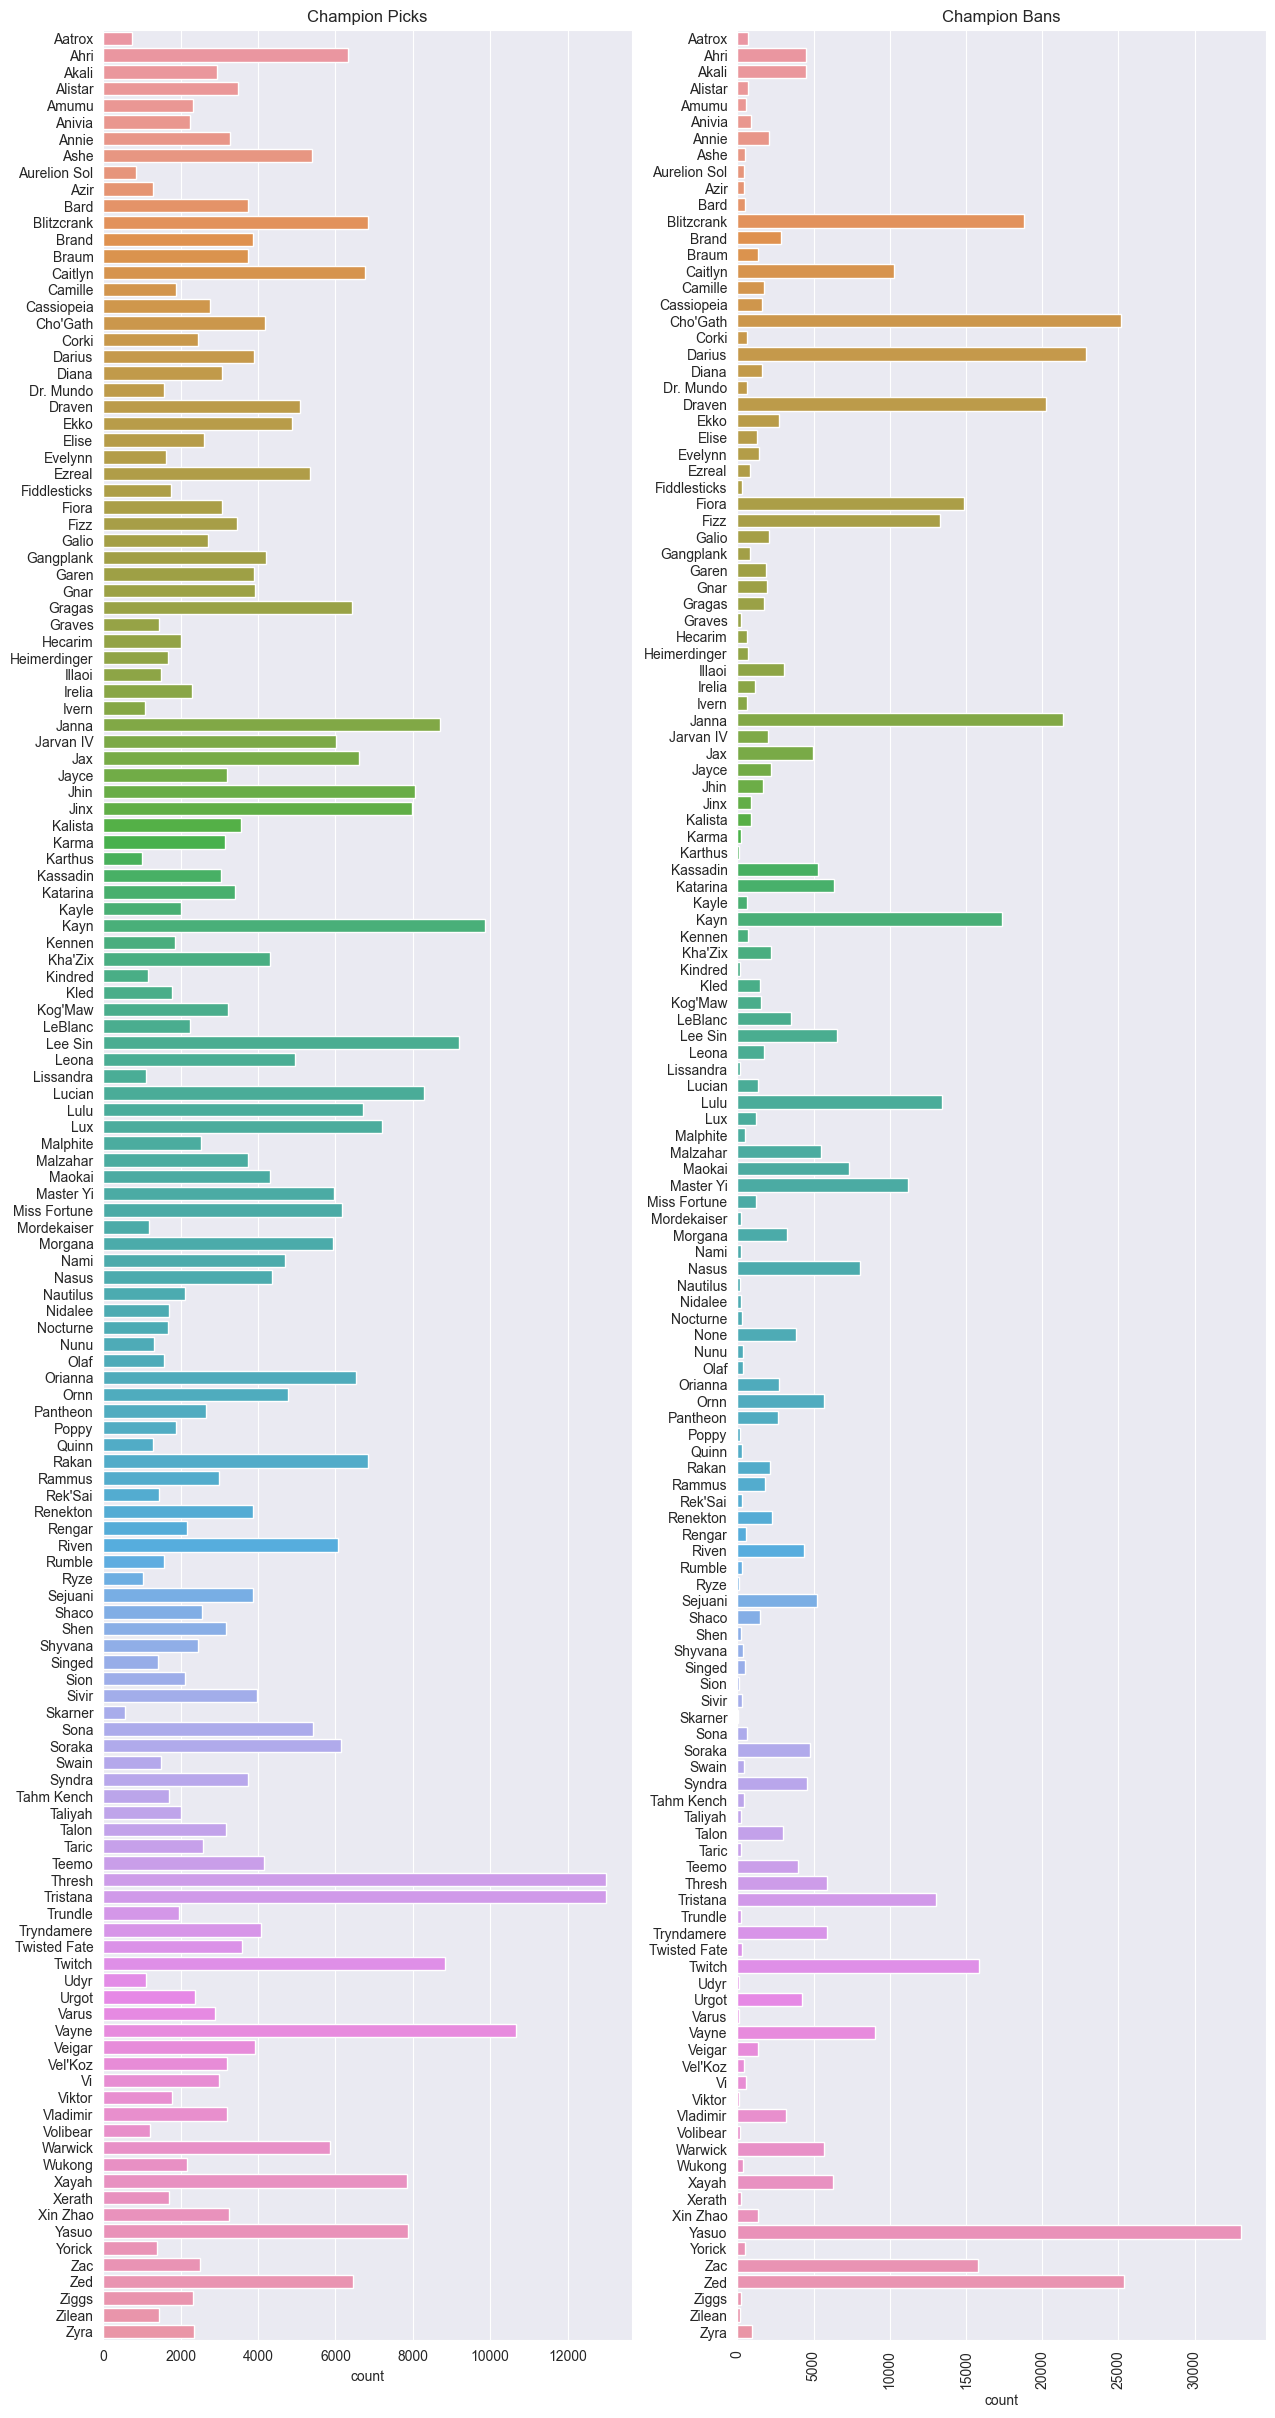

In [76]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,30))
plt.xticks(rotation=90)
sns.countplot(y=sortedPicks, data=df, ax=ax1)
sns.countplot(y=sortedBans, data=df, ax=ax2)
ax1.set_title('Champion Picks')
ax2.set_title('Champion Bans')

In [77]:
#extraemos las columnas de ganadores y las de los integrantes  del equipo ganador
Winning_Champion = df[['winner', 't1_champ1id','t1_champ2id','t1_champ3id','t1_champ4id','t1_champ5id',
             't2_champ1id','t2_champ2id','t2_champ3id','t2_champ4id','t2_champ5id']]

# Mostrar los resultados
Winning_Champion

,winner,t1_champ1id,t1_champ2id,t1_champ3id,t1_champ4id,t1_champ5id,t2_champ1id,t2_champ2id,t2_champ3id,t2_champ4id,t2_champ5id
0,1,Vladimir,Bard,Kog'Maw,Master Yi,Viktor,Graves,Xayah,Darius,Zed,Thresh
1,1,Draven,Irelia,Nidalee,Kayle,Shaco,Malphite,Morgana,Hecarim,Yasuo,Riven
2,1,Tristana,Kayn,Nami,Rumble,Kassadin,Cassiopeia,Thresh,Jayce,Jax,Ashe
3,1,Maokai,Brand,Twitch,Orianna,Dr. Mundo,Malzahar,Warwick,Thresh,Riven,Ashe
4,1,Warwick,Twitch,Janna,Draven,Syndra,Sona,Jarvan IV,Kayn,Kassadin,Caitlyn
...,...,...,...,...,...,...,...,...,...,...,...
51485,2,Warwick,Kalista,Talon,Bard,Lee Sin,Veigar,Yorick,Vayne,Janna,Gragas
51486,2,Malzahar,Amumu,Cho'Gath,Thresh,Tristana,Shyvana,Kalista,Leona,Nasus,Veigar
51487,2,Kayn,Tristana,Bard,Ezreal,Rumble,Annie,Draven,Rammus,Karma,Lux
51488,2,Kha'Zix,Lucian,Illaoi,Braum,Lux,Miss Fortune,Nocturne,Morgana,Karthus,Master Yi


In [78]:
team_1 = Winning_Champion['winner'] == 1 
winT1 = df.loc[team_1, ['t1_champ1id','t1_champ2id','t1_champ3id','t1_champ4id','t1_champ5id']]
winT1

,t1_champ1id,t1_champ2id,t1_champ3id,t1_champ4id,t1_champ5id
0,Vladimir,Bard,Kog'Maw,Master Yi,Viktor
1,Draven,Irelia,Nidalee,Kayle,Shaco
2,Tristana,Kayn,Nami,Rumble,Kassadin
3,Maokai,Brand,Twitch,Orianna,Dr. Mundo
4,Warwick,Twitch,Janna,Draven,Syndra
...,...,...,...,...,...
51472,Gnar,Nocturne,Draven,Rakan,Taliyah
51476,Xayah,Leona,Akali,Irelia,Shaco
51479,Jinx,Rakan,Gangplank,Zed,Sejuani
51481,Evelynn,Gragas,Xin Zhao,Jinx,Lissandra


In [79]:
team_2 = Winning_Champion['winner'] == 2 
winT2 = df.loc[team_2, ['t1_champ1id','t1_champ2id','t1_champ3id','t1_champ4id','t1_champ5id']]
winT2

,t1_champ1id,t1_champ2id,t1_champ3id,t1_champ4id,t1_champ5id
8,Nautilus,Maokai,Tristana,Nami,Vel'Koz
9,Ivern,Master Yi,Nasus,Kalista,Diana
10,Lux,Lucian,Zyra,Maokai,Nautilus
14,Janna,Ahri,Xayah,Riven,Kayn
16,Vayne,Janna,Azir,Xin Zhao,Riven
...,...,...,...,...,...
51484,Varus,Brand,LeBlanc,Shaco,Cho'Gath
51485,Warwick,Kalista,Talon,Bard,Lee Sin
51486,Malzahar,Amumu,Cho'Gath,Thresh,Tristana
51487,Kayn,Tristana,Bard,Ezreal,Rumble


In [80]:
columanas_eliminar = ['gameId', 'creationTime', 'seasonId',
                      't1_champ1id','t1_champ2id','t1_champ3id','t1_champ4id','t1_champ5id',
             't2_champ1id','t2_champ2id','t2_champ3id','t2_champ4id','t2_champ5id',
            't1_ban1','t1_ban2','t1_ban3','t1_ban4','t1_ban5', 't2_ban1','t2_ban2','t2_ban3','t2_ban4','t2_ban5',
            't1_champ1_sum1','t1_champ1_sum2','t1_champ2_sum1','t1_champ2_sum2','t1_champ3_sum1','t1_champ3_sum2',
                 't1_champ4_sum1','t1_champ4_sum2','t1_champ5_sum1','t1_champ5_sum2','t2_champ1_sum1','t2_champ1_sum2',
                 't2_champ2_sum1','t2_champ2_sum2','t2_champ3_sum1','t2_champ3_sum2','t2_champ4_sum1','t2_champ4_sum2',
                 't2_champ5_sum1','t2_champ5_sum2']
df = df.drop(columanas_eliminar, axis=1)
df.head()

,gameDuration,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t1_riftHeraldKills,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills
0,1949,1,2,1,1,1,1,2,11,1,2,3,0,5,0,0,1,1
1,1851,1,1,1,1,0,1,1,10,4,0,2,1,2,0,0,0,0
2,1493,1,2,1,1,1,2,0,8,1,1,1,0,2,0,0,1,0
3,1758,1,1,1,1,1,1,0,9,2,1,2,0,0,0,0,0,0
4,2094,1,2,1,1,1,1,0,9,2,1,3,0,3,0,0,1,0


In [81]:
df.corr()

,gameDuration,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t1_riftHeraldKills,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills
gameDuration,1.000000,0.024187,0.105022,0.216842,0.379996,0.487788,0.255563,0.011690,0.369478,0.301616,0.397987,0.409414,0.006769,0.396769,0.319451,0.429793,0.416995,0.007818
winner,0.024187,1.000000,0.174770,0.375697,0.536437,0.261888,0.310386,0.119813,-0.771541,-0.649405,-0.369472,-0.472483,-0.218066,0.785813,0.660452,0.399249,0.497206,0.226102
firstBlood,0.105022,0.174770,1.000000,0.263866,0.169761,0.077293,0.189092,0.084062,-0.128116,-0.098918,-0.030571,-0.082820,-0.081243,0.223657,0.151111,0.076395,0.161045,0.122195
firstTower,0.216842,0.375697,0.263866,1.000000,0.380326,0.165028,0.403552,0.185989,-0.316477,-0.240035,-0.056867,-0.201023,-0.188326,0.511296,0.347641,0.161308,0.364361,0.274713
firstInhibitor,0.379996,0.536437,0.169761,0.380326,1.000000,0.417848,0.352760,0.166521,-0.276349,-0.269425,-0.076762,-0.161124,-0.100527,0.755335,0.699832,0.400133,0.487373,0.211380
firstBaron,0.487788,0.261888,0.077293,0.165028,0.417848,1.000000,0.201065,0.120714,-0.003740,-0.026035,0.134069,0.082034,-0.009653,0.460115,0.385864,0.793114,0.393952,0.121126
firstDragon,0.255563,0.310386,0.189092,0.403552,0.352760,0.201065,1.000000,0.159429,-0.190550,-0.164399,-0.045496,-0.386488,-0.102283,0.427092,0.299977,0.195352,0.629794,0.205444
firstRiftHerald,0.011690,0.119813,0.084062,0.185989,0.166521,0.120714,0.159429,1.000000,-0.083813,-0.059551,0.008027,-0.058104,0.189081,0.188240,0.141677,0.101231,0.150173,0.866779
t1_towerKills,0.369478,-0.771541,-0.128116,-0.316477,-0.276349,-0.003740,-0.190550,-0.083813,1.000000,0.824471,0.490723,0.626743,0.283925,-0.549123,-0.469600,-0.158556,-0.313789,-0.224888
t1_inhibitorKills,0.301616,-0.649405,-0.098918,-0.240035,-0.269425,-0.026035,-0.164399,-0.059551,0.824471,1.000000,0.481606,0.538469,0.210728,-0.467867,-0.408924,-0.153026,-0.279089,-0.164355


In [82]:
df.winner.value_counts()

winner
1    26077
2    25413
Name: count, dtype: int64

In [84]:
def split_dataset(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=221)
    return X_train, X_test, y_train, y_test

In [98]:
def exactitud(TP, TN, FP, FN):
    a = (TP + TN) / (TP + TN + FP + FN)
    accuracy_valor = a * 100
    return accuracy_valor

def sensibilidad(TP, TN, FP, FN):
    s = TP / (TP + FN)
    sensibilidad_valor = s * 100
    return sensibilidad_valor

def especificidad(TP, TN, FP, FN):
    e = TN / (TN + FP)
    especificidad_valor = e * 100
    return especificidad_valor

def evaluar_modelo(y_test, y_pred):
    matrix = confusion_matrix(y_test, y_pred)
    (TN, FP, FN, TP) = matrix.ravel()
    
    accuracy_valor = exactitud(TP, TN, FP, FN)
    sensibilidad_valor= sensibilidad(TP, TN, FP, FN)
    especificidad_valor = especificidad(TP, TN, FP, FN)
    #print(f"Exactitud: {accuracy_valor}")
    #print(f"Sensibilidad: {sensibilidad_valor}")
    #print(f"Especificidad: {especificidad_valor}")
    return accuracy_valor, sensibilidad_valor, especificidad_valor

In [87]:
def confussion_matrix(y_test, y_pred, model_name):
    m = confusion_matrix(y_test, y_pred)
    cm_object = ConfusionMatrixDisplay(m).plot(cmap=plt.cm.Blues)
    cm_object.ax_.set(
                        title = model_name,
                        xlabel = 'Predicted',
                        ylabel = 'Actual')

In [90]:
y = df.winner
X = df.copy()
X = X.drop('winner', axis=1)

X

,gameDuration,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t1_riftHeraldKills,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills
0,1949,2,1,1,1,1,2,11,1,2,3,0,5,0,0,1,1
1,1851,1,1,1,0,1,1,10,4,0,2,1,2,0,0,0,0
2,1493,2,1,1,1,2,0,8,1,1,1,0,2,0,0,1,0
3,1758,1,1,1,1,1,0,9,2,1,2,0,0,0,0,0,0
4,2094,2,1,1,1,1,0,9,2,1,3,0,3,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,1944,1,2,2,0,2,0,2,0,0,0,0,10,2,0,4,0
51486,3304,1,1,2,2,2,2,5,4,0,2,0,11,7,4,4,1
51487,2156,2,2,2,0,1,0,0,0,0,1,0,10,2,0,2,0
51488,1475,2,2,2,0,2,0,0,0,0,0,0,11,3,0,1,0


In [91]:
y

0        1
1        1
2        1
3        1
4        1
        ..
51485    2
51486    2
51487    2
51488    2
51489    1
Name: winner, Length: 51490, dtype: int64

In [92]:
#Normalizacion
scaler = StandardScaler()
dataset_normalizada = scaler.fit_transform(X)
X = dataset_normalizada.copy()
X_train, X_test, y_train, y_test = split_dataset(X,y)
len(X_train), len(X_test), len(y_train), len(y_test)

(36043, 15447, 36043, 15447)

97.22276170130122 96.94197595399896 97.49839640795382


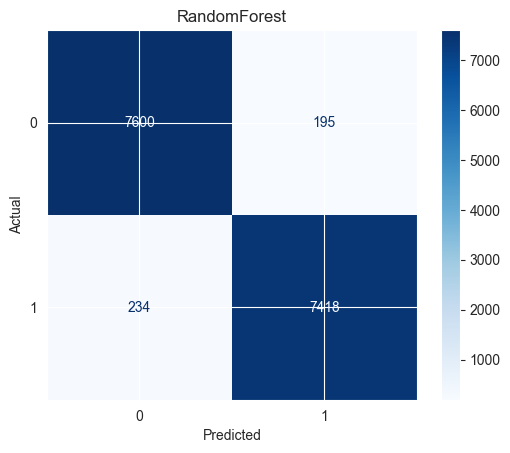

In [94]:
modelo = RandomForestClassifier()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
accuracy, sensibilidad, especificidad = evaluar_modelo(y_test, y_pred)
print(accuracy, sensibilidad, especificidad)
confussion_matrix(y_test, y_pred, 'RandomForest')

96.42001683174726 96.35389440669107 96.48492623476588


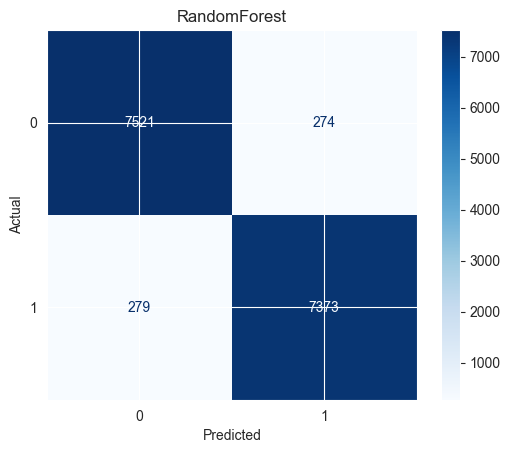

In [99]:
from sklearn.linear_model import LogisticRegression
modelo2 = LogisticRegression()
modelo2.fit(X_train, y_train)
y_pred2 = modelo2.predict(X_test)
accuracy, sensibilidad, especificidad = evaluar_modelo(y_test, y_pred2)
print(accuracy, sensibilidad, especificidad)
confussion_matrix(y_test, y_pred2, 'RandomForest')